# Exercise
**file name**: `clustering_anomaly_detection.py` or `clustering_anomaly_detection.ipynb`

# Experiment with the DBSCAN properties
- Read up on the epsilon and min_samples arguments into DBSCAN at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


#used for DBclustering and scaling
from sklearn.cluster import DBSCAN
#using MinMax b'c Standard can have LESSTHAN 0, and Epsolon is 0-1 only
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import wrangle as w

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")

In [4]:
df.head(2)

Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  \
customer_id                                                                    
0                  2       3  12669  9656     7561     214              2674   
1                  2       3   7057  9810     9568    1762              3293   

             Delicassen  
customer_id              
0                  1338  
1                  1776

In [5]:
# cluster on subset of features
grocery_milk_fresh = df[["Grocery", "Milk","Fresh"]]

In [6]:
grocery_milk_fresh.head(2)

Grocery  Milk  Fresh
customer_id                      
0               7561  9656  12669
1               9568  9810   7057

In [7]:
grocery_milk_fresh.columns

Index(['Grocery', 'Milk', 'Fresh'], dtype='object')

In [8]:
scaler = MinMaxScaler().fit(grocery_milk_fresh)
grocery_milk_fresh = scaler.transform(grocery_milk_fresh)

- Experiment with altering the epsilon values (the eps argument holding the threshhold parameter). Run the models and visualize the results. What has changed? Why do you think that is?

In [9]:
dbsc = DBSCAN(eps = .50, min_samples = 20).fit(grocery_milk_fresh)

In [10]:
gmf_columns = ['Grocery', 'Milk', 'Fresh']

In [11]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)

scaled_columns = ["Scaled_" + column for column in gmf_columns]

In [12]:
# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_milk_fresh, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [13]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
df['labels'] = labels
df.labels.value_counts()

 0    439
-1      1
Name: labels, dtype: int64

In [15]:
df[df.labels==-1].head()

Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
85        2       3  16117  46197    92780    1026             40827   

    Delicassen  Scaled_Grocery  Scaled_Milk  Scaled_Fresh  labels  
85        2944             1.0      0.62827      0.143685      -1

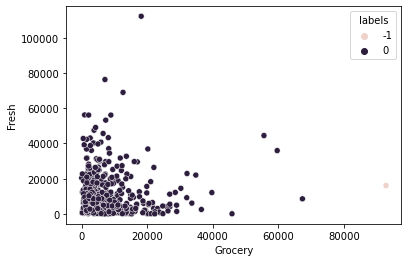

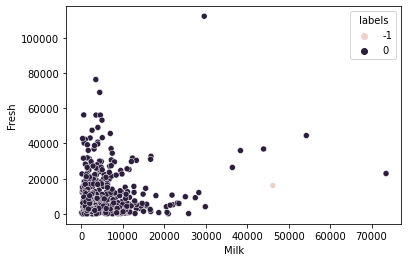

In [16]:
sns.scatterplot(df.Grocery, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Milk, df.Fresh, hue=df.labels)
plt.show()

In [17]:

%matplotlib qt

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Milk, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

Text(0.5, 0, 'Grocery')

𝛆 = 1.0


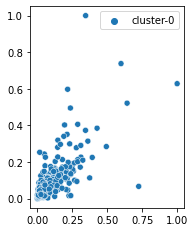

𝛆 = 0.5


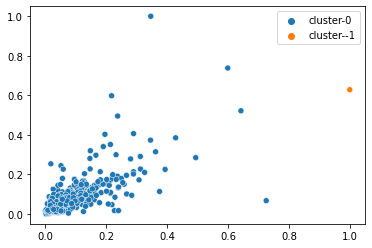

𝛆 = 0.3333333333333333


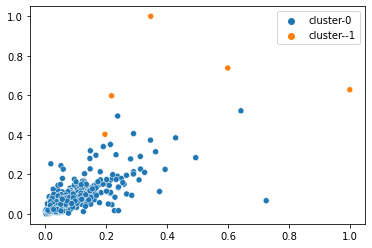

𝛆 = 0.25


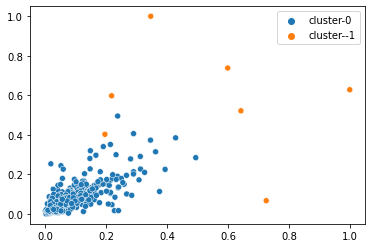

𝛆 = 0.2


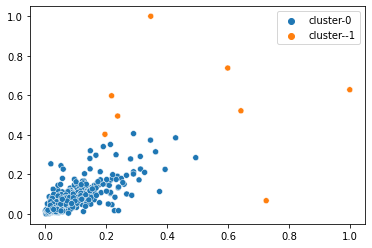

𝛆 = 0.16666666666666666


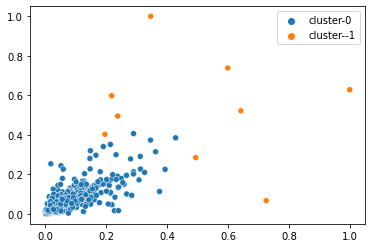

𝛆 = 0.14285714285714285


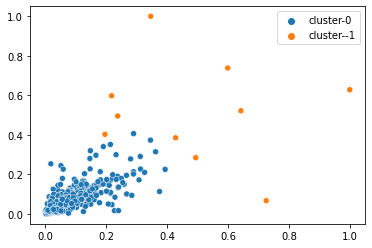

𝛆 = 0.125


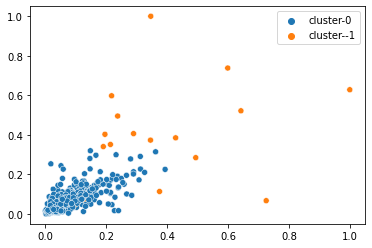

𝛆 = 0.1111111111111111


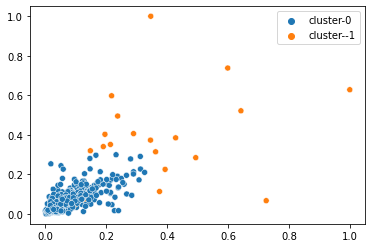

𝛆 = 0.1


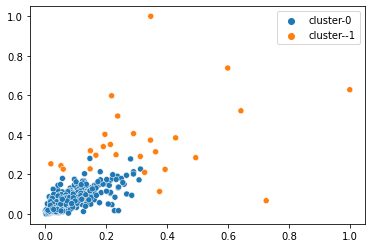

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=.7, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=25).fit(grocery_milk_fresh)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    ax = fig.add_subplot(2, 5, i)
    print(f'𝛆 = {eps}')
    sns.scatterplot(grocery_milk_fresh[:,0], grocery_milk_fresh[:,1], hue=["cluster-{}".format(x) for x in labels])
    i += 1
    plt.show()

- Double the `min_samples` parameter. Run your model and visualize the results. Consider what changed and why.

min_sample = 0


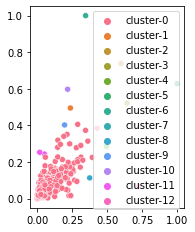

min_sample = 20


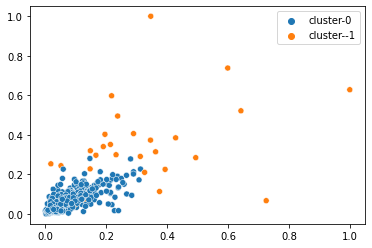

min_sample = 40


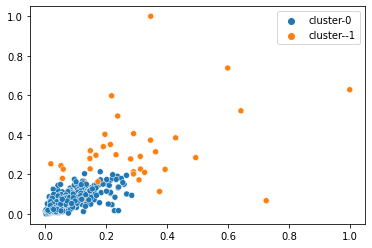

min_sample = 60


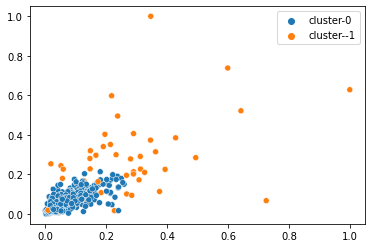

In [19]:
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=.7, wspace=.2)
i = 1
for x in range(4):
    minsample = 20*x
    db = DBSCAN(eps=0.1, min_samples=minsample).fit(grocery_milk_fresh)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    ax = fig.add_subplot(2, 5, i)
    print(f'min_sample = {minsample}')
    sns.scatterplot(grocery_milk_fresh[:,0], grocery_milk_fresh[:,1], hue=["cluster-{}".format(x) for x in labels])
    i += 1
    plt.show()

***
## Clustering - DBSCAN
Use DBSCAN to detect anomalies in other products from the customers dataset.

In [20]:
# cluster on subset of features
grocery_frozen_deli = df[["Grocery", "Frozen","Delicassen"]]

In [21]:
grocery_frozen_deli.head(2)

Grocery  Frozen  Delicassen
0     7561     214        1338
1     9568    1762        1776

In [22]:
grocery_frozen_deli.columns

Index(['Grocery', 'Frozen', 'Delicassen'], dtype='object')

In [23]:
gfd_columns = ['Grocery', 'Frozen', 'Delicassen']

In [24]:
# scale
scaler = MinMaxScaler().fit(grocery_frozen_deli)
grocery_frozen_deli = scaler.transform(grocery_frozen_deli)

In [25]:
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(grocery_frozen_deli)

In [26]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)

scaled_columns = ["Scaled_" + column for column in gfd_columns]

In [27]:
# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_frozen_deli, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

𝛆 = 1.0


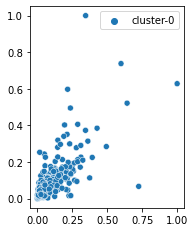

𝛆 = 0.5


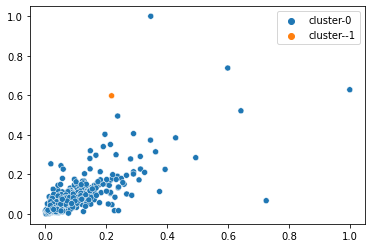

𝛆 = 0.3333333333333333


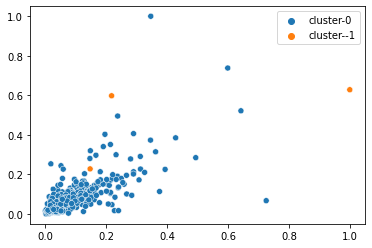

𝛆 = 0.25


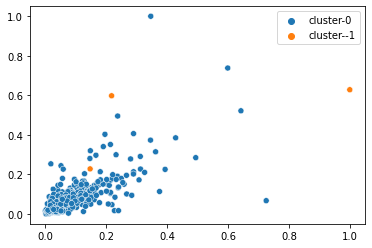

𝛆 = 0.2


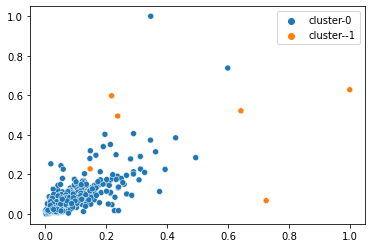

𝛆 = 0.16666666666666666


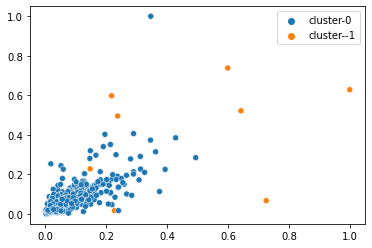

𝛆 = 0.14285714285714285


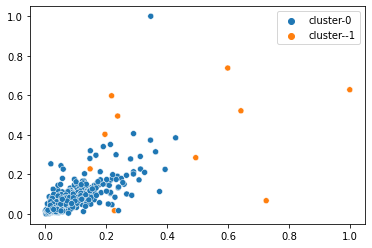

𝛆 = 0.125


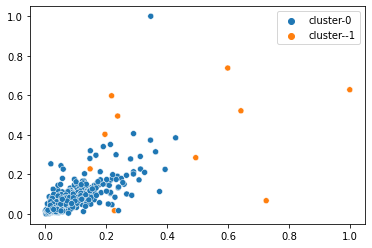

𝛆 = 0.1111111111111111


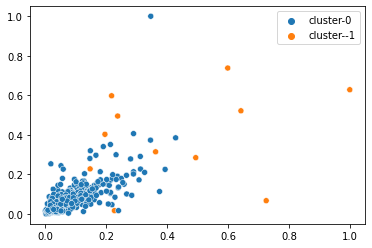

𝛆 = 0.1


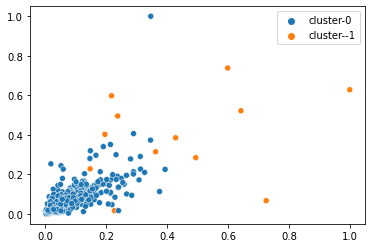

In [28]:
%matplotlib inline
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(hspace=.7, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=20).fit(grocery_frozen_deli)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    ax = fig.add_subplot(2, 5, i)
    print(f'𝛆 = {eps}')
    sns.scatterplot(grocery_milk_fresh[:,0], grocery_milk_fresh[:,1], hue=["cluster-{}".format(x) for x in labels])
    i += 1
    plt.show()

In [29]:
%matplotlib qt

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Delicassen, df.Frozen, df.Grocery,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Delicassen')
ax.set_ylabel('Frozen')
ax.set_zlabel('Grocery')

Text(0.5, 0, 'Grocery')

___
# Use DBSCAN to detect anomalies in: 
- number of bedrooms and 
- finished square feet of property 

for the filtered dataset you used in the `clustering project` (single unit properties with a logerror).

In [30]:
zlo = w.zillow17()

In [31]:
zlo.shape

(77574, 68)

In [32]:
zlo.head(2)

id  parcelid  airconditioningtypeid  architecturalstyletypeid  \
0  1727539  14297519                    NaN                       NaN   
1  1387261  17052889                    NaN                       NaN   

   basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
0           NaN          3.5         4.0                  NaN   
1           NaN          1.0         2.0                  NaN   

   buildingqualitytypeid  calculatedbathnbr  ...  censustractandblock  \
0                    NaN                3.5  ...         6.059063e+13   
1                    NaN                1.0  ...         6.111001e+13   

   logerror  transactiondate  airconditioningdesc  architecturalstyledesc  \
0  0.025595       2017-01-01                 None                    None   
1  0.055619       2017-01-01                 None                    None   

   buildingclassdesc  heatingorsystemdesc        propertylandusedesc  \
0               None                 None  Single Family Residential   
1               None                 None  Single Family Residential   

   storydesc  typeconstructiondesc  
0       None                  None  
1       None                  None  

[2 rows x 68 columns]

In [33]:
zlo = w.clean_zillow(zlo)

In [34]:
zlo.shape

(45788, 18)

In [35]:
zlo.head(2)

parcelid  bathrooms  bedrooms  property_quality    sqft  fips    latitude  \
3  12177905        3.0         4                 8  2376.0  6037  34245180.0   
4  10887214        3.0         3                 8  1312.0  6037  34185120.0   

     longitude  lot_sqft  yearbuilt  structure_value  home_value  land_value  \
3 -118240722.0   13038.0       1970         108918.0    145143.0     36225.0   
4 -118414640.0  278581.0       1964          73681.0    119407.0     45726.0   

   taxamount  logerror       county  home_age logerror_quartiles  
3    1777.51  -0.10341  Los_Angeles        51                 q1  
4    1533.89   0.00694  Los_Angeles        57                 q3

In [36]:
# cluster on subset of features
bdrmsqft = zlo[["bedrooms", "sqft"]]

In [37]:
bdrmsqft.shape

(45788, 2)

In [38]:
bdrmsqft.head(2)

bedrooms    sqft
3         4  2376.0
4         3  1312.0

In [39]:
#create a list of column names from clustered subset of features: nu_df
columns = bdrmsqft.columns.to_list()

In [40]:
columns

['bedrooms', 'sqft']

In [41]:
#scale and transform the DF
scaler = MinMaxScaler().fit(bdrmsqft)
bdrmsqft = scaler.transform(bdrmsqft)

In [42]:
bdrmsqft.shape

(45788, 2)

In [43]:
#Construct a DBSCAN object 
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(bdrmsqft)

In [44]:
#add the scaled value columns back onto the dataframe
scaled_columns = ["Scaled_" + column for column in columns]

In [45]:
scaled_columns

['Scaled_bedrooms', 'Scaled_sqft']

In [46]:
# Save a copy of the original dataframe
original_zlo = zlo.copy()

In [47]:
original_zlo.shape

(45788, 18)

In [48]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(bdrmsqft, columns=scaled_columns)

In [49]:
scaled_df.head(2)

Scaled_bedrooms  Scaled_sqft
0              0.3     0.162507
1              0.2     0.070289

In [50]:
# Merge the scaled and non-scaled values into one dataframe
zlo = zlo.merge(scaled_df, on=zlo.index)

In [51]:
zlo.shape

(45788, 21)

In [52]:
zlo = zlo.drop(columns=['key_0'])

In [53]:
zlo.tail(2)

parcelid  bathrooms  bedrooms  property_quality    sqft  fips  \
45786  12773139        1.0         3                 4  1032.0  6037   
45787  12826780        2.0         3                 6  1762.0  6037   

         latitude    longitude  lot_sqft  yearbuilt  structure_value  \
45786  34040895.0 -118038169.0    5074.0       1954          32797.0   
45787  33937685.0 -117996709.0    6347.0       1955         140000.0   

       home_value  land_value  taxamount  logerror       county  home_age  \
45786     49546.0     16749.0     876.43  0.037129  Los_Angeles        67   
45787    522000.0    382000.0    6317.15  0.007204  Los_Angeles        66   

      logerror_quartiles  Scaled_bedrooms  Scaled_sqft  
45786                 q3              0.2     0.046022  
45787                 q3              0.2     0.109291

In [54]:
zlo.shape

(45788, 20)

In [55]:
#extract cluster labels and outliers 
labels = dbsc.labels_
zlo['labels'] = labels

In [56]:
sns.scatterplot(zlo.bathrooms, zlo.sqft, hue=df.labels)
plt.show()

In [64]:
def densitybasedcluster(df, nu_df, epsilon, mins):
    """
    takes in 
    -df: original df
    -nu_df: df made of clustered subset of features::: nu_df = df[['feat1', 'feat2', ...]]
    -epsilon: number between 0 & 1 
    -mins: number of minimum data points in a neighborhood radius
    
    """
    #create a list of column names from clustered subset of features: nu_df
    columns = nu_df.columns.to_list()
    
    #scale and transform the DF
    scaler = MinMaxScaler().fit(nu_df)
    nu_df = scaler.transform(nu_df)
    
    #Construct a DBSCAN object 
    dbsc = DBSCAN(eps = epsilon, min_samples = mins).fit(nu_df)
    
    #add the scaled value columns back onto the dataframe
    scaled_columns = ["Scaled_" + column for column in columns]
    
    # Save a copy of the original dataframe
    original_df = df.copy()
    
    # Create a dataframe containing the scaled values
    scaled_df = pd.DataFrame(nu_df, columns=scaled_columns)
    
    # Merge the scaled and non-scaled values into one dataframe
    df = df.merge(scaled_df, on=df.index)
    df = df.drop(columns=['key_0'])
    
    #extract cluster labels and outliers 
    labels = dbsc.labels_
    df['labels'] = labels

In [71]:
# cluster on subset of features
bdrmsqft = zlo[["bedrooms", "sqft"]]

In [72]:
densitybasedcluster(zlo, bdrmsqft, 0.5, 20)

𝛆 = 0.1


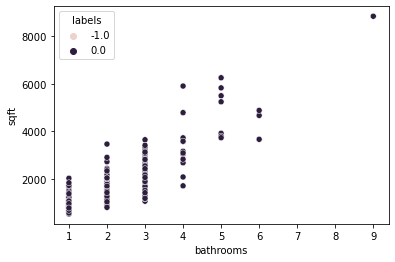

In [73]:
%matplotlib inline

sns.scatterplot(zlo.bathrooms, zlo.sqft, hue=df.labels)
print(f"𝛆 = {eps}")
plt.show()